In [12]:
# THIS NOTEBOOK IS FOR PREPROCESSING THE 300micron square structure EMX data
import os
import skrf as rf
import numpy as np
from tqdm.auto import tqdm

RESULTS_DIR = "/home/sbfisher/Cadence/Thesis/PythonCode/Test_Results300/"   # processing 300x300 structures
# DATA_DIR = "/scratch/gpfs/sbfisher/EM300/data/"
DATA_DIR = "/scratch/gpfs/sbfisher/EM300/data/"   # processing 300x300 structures, put them here

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

# count = total number of datapoints we can make from this data
count = len(os.listdir(RESULTS_DIR))//2 * 6
y_dataset = np.zeros([count, 54])
x_dataset = np.zeros([count, 18, 18])




    

i = 0
# print(len(os.listdir(RESULTS_DIR)))
for filename in tqdm(os.listdir(RESULTS_DIR)):
    # break
    # print(filename)
    if "struct" in filename:
        continue

    # print(filename)
        
    # Parse number
    trial_num = filename.split("_")[1]

    # Load data from s-param file
    sparam_file = "{}{}".format(RESULTS_DIR, filename)
    with open(sparam_file, 'r') as f:
        em_struct_net = rf.Network(f)
        # print(em_struct_net)
        freq = rf.Frequency(start=3, stop=100, npoints=98, unit='ghz')
        s = -1 * np.ones(98)  # random complex numbers
        # if not passed, will assume z0=50. name is optional but it's a good practice.
        short = rf.Network(frequency=freq, s=s, name='short')
        # print(short)
        # maybe need to make short only as long as em_struct_net??
        
        # Short all metal ports (should be last 4) to ground
        grounded = rf.connect(em_struct_net, 4, short, 0)
        grounded = rf.connect(grounded, 4, short, 0)
        grounded = rf.connect(grounded, 4, short, 0)
        grounded = rf.connect(grounded, 4, short, 0)

        # Create six structures from one.
        # First is normal, short top and bottom to ground, left and right are inputs
        # (grounded ** short) ** short
        net_1 = rf.connect(rf.connect(grounded, 3, short, 0), 2, short, 0)
        params_1 = net_1.s
        # only inclue 71 (30-100GHz) data points
        if len(net_1.s) > 71:
            params_1 = net_1.s[-71:,:,:]
        
        # Second is same as first but flipped over x axis. nothing changes in s_param matrix
        params_2 = params_1.copy()
        
        # Third is same as first but flipped over y axis, s11 and s22 flip.
        # net_3 = rf.Network(frequency=freq, s=rf.network.flip(net_1.s), name="net3")
        params_3 = np.flip(params_1, axis=(1,2))

        # Fourth is different, short left and right to ground, (so rotate structure 90deg cc),
        # top and bottom are input/output
        net_4 = rf.connect(rf.connect(grounded, 0, short, 0), 0, short, 0)
        print(net_4)
        # this will be bottom port1, top port2, so flip
        net_4.flip()
        params_4 = net_4.s
        if len(net_4.s) > 71:
            params_4 = net_4.s[-71:,:,:]

        # Fifth is same as fourth but rotated about x axis, so s mat stays the same
        params_5 = params_4.copy()

        # Sixth is the same as fourth but rotated about y axis, so s mat flips (this is above)
        params_6 = np.flip(params_4, axis=(1,2))


    # Add 6 items to the y dataset for the 6 permutations of the structure
    # y_dataset items should be 54 long
    # s11 s21 s22
    # 9 frequency points of (Re(s11) Im(s11) Re(s21) Im(s21) Re(s22) Im(s22))
    # 30, 37, 40, 50, 60, 70, ..., 100
    # First all s11, then all s21, then all s22 points
    params = [params_1, params_2, params_3, params_4, params_5, params_6]
    to_add = 6
    y_data = np.zeros([to_add, 54])
    n = 9
    for j in range(to_add):
        y_data[j, :n] = np.real(params[j][idxs,0,0]) # Re(s11)
        y_data[j, n:2*n] = np.imag(params[j][idxs,0,0]) # Im(s11)
        y_data[j, 2*n:3*n] = np.real(params[j][idxs,0,1]) # Re(s12)
        y_data[j, 3*n:4*n] = np.imag(params[j][idxs,0,1]) # Im(s12)
        y_data[j, 4*n:5*n] = np.real(params[j][idxs,1,1]) # Re(s22)
        y_data[j, 5*n:6*n] = np.imag(params[j][idxs,1,1]) # Im(s22)

    # print(idxs)
    # print(params_5[idxs])
    # print(y_data[4])
    # print(params_1[20])
    y_dataset[i:i+to_add] = y_data
    
    struct_file = "{}trial_{}_struct.txt".format(RESULTS_DIR,trial_num)
    # Load struct from txt file
    with open(struct_file, 'r') as f:
        data = f.readlines()
        data = np.array([int(x) for x in data[0].split()]).reshape([18,18])

        # Apply 6 transforms to matrix input to get different data points for dataset
        # 1 (normal)
        data_1 = data

        # 2 (flip up/down)
        data_2 = np.flipud(data)

        # 3 (flip left/right)
        data_3 = np.fliplr(data)

        # 4 (rotate 90 CC)
        data_4 = np.rot90(data)

        # 5 (flip up/down after rot90)
        data_5 = np.flipud(data_4)

        # 6 (flip left/right after rot90)
        data_6 = np.fliplr(data_4)

    # Add 6 data points (18x18 matrices) to x_dataset
    x_data = np.stack([data_1, data_2, data_3, data_4, data_5, data_6])
    x_dataset[i:i+to_add] = x_data

    i += to_add

print(y_data[0].shape)



# np.save(DATA_DIR + "x_data.npy", x_dataset)
# np.save(DATA_DIR + "y_data.npy", y_dataset)


[ 0  7 10 20 30 40 50 60 70]


  0%|          | 0/104371 [00:00<?, ?it/s]

trial_0_data.s8p
2-Port Network: 'trial_0_data',  3000000000.0-100000000000.0 Hz, 98 pts, z0=[50.+0.j 50.+0.j]
(54,)


In [91]:
import matplotlib.pyplot as plt
def preprocess_data(trial_name=""):
    RESULTS_DIR = "/home/sbfisher/Cadence/Thesis/PythonCode/Test_Results300/"
    # Parse number
    filename = trial_name
    trial_num = filename.split("_")[1]

    # Load data from s-param file
    sparam_file = "{}{}".format(RESULTS_DIR, filename)
    with open(sparam_file, 'r') as f:
        em_struct_net = rf.Network(f)
        # print(em_struct_net)
        # print(em_struct_net)
        freq = rf.Frequency(start=3, stop=100, npoints=98, unit='ghz')
        s = -1 * np.ones(98)  # random complex numbers
        # if not passed, will assume z0=50. name is optional but it's a good practice.
        short = rf.Network(frequency=freq, s=s, name='short')
        # print(short)
        # maybe need to make short only as long as em_struct_net??
        
        # Short all metal ports (should be last 4) to ground
        grounded = rf.connect(em_struct_net, 4, short, 0)
        grounded = rf.connect(grounded, 4, short, 0)
        grounded = rf.connect(grounded, 4, short, 0)
        grounded = rf.connect(grounded, 4, short, 0)

        # Create six structures from one.
        # First is normal, short top and bottom to ground, left and right are inputs
        # (grounded ** short) ** short
        net_1 = rf.connect(rf.connect(grounded, 3, short, 0), 2, short, 0)
        params_1 = net_1.s
        # only inclue 71 (30-100GHz) data points
        if len(net_1.s) > 71:
            params_1 = net_1.s[-71:,:,:]
        
        # Second is same as first but flipped over x axis. nothing changes in s_param matrix
        params_2 = params_1.copy()
        
        # Third is same as first but flipped over y axis, s11 and s22 flip.
        # net_3 = rf.Network(frequency=freq, s=rf.network.flip(net_1.s), name="net3")
        params_3 = np.flip(params_1, axis=(1,2))

        # Fourth is different, short left and right to ground, (so rotate structure 90deg cc),
        # top and bottom are input/output
        net_4 = rf.connect(rf.connect(grounded, 0, short, 0), 0, short, 0)
        print(net_4)
        # this will be bottom port1, top port2, so flip
        net_4.flip()
        params_4 = net_4.s
        if len(net_4.s) > 71:
            params_4 = net_4.s[-71:,:,:]

        # Fifth is same as fourth but rotated about x axis, so s mat stays the same
        params_5 = params_4.copy()

        # Sixth is the same as fourth but rotated about y axis, so s mat flips (this is above)
        params_6 = np.flip(params_4, axis=(1,2))


    # Add 6 items to the y dataset for the 6 permutations of the structure
    # y_dataset items should be 54 long
    # s11 s21 s22
    # 9 frequency points of (Re(s11) Im(s11) Re(s21) Im(s21) Re(s22) Im(s22))
    # 30, 37, 40, 50, 60, 70, ..., 100
    # First all s11, then all s21, then all s22 points
    # indexes of frequencies to get from sparam array
    freqs = [30,37]
    freqs.extend([x for x in range(40,101,10)])
    idxs = np.array([x - 30 for x in freqs])
    print(idxs)

    params = [params_1, params_2, params_3, params_4, params_5, params_6]
    to_add = 6
    y_data = np.zeros([to_add, 54])
    n = 9
    for j in range(to_add):
        s11 = np.real(params[j][idxs,0,0]) # Re(s11)
        s11_im = np.imag(params[j][idxs,0,0]) # Im(s11)
        s12 = np.real(params[j][idxs,0,1]) # Re(s12)
        s12_im = np.imag(params[j][idxs,0,1]) # Im(s12)
        s22 = np.real(params[j][idxs,1,1]) # Re(s22)
        s22_im = np.imag(params[j][idxs,1,1]) # Im(s22)
        
        y_data[j, :n] = s11
        y_data[j, n:2*n] = s11_im
        y_data[j, 2*n:3*n] = s12
        y_data[j, 3*n:4*n] = s12_im
        y_data[j, 4*n:5*n] = s22
        y_data[j, 5*n:6*n] = s22_im

    # print(idxs)
    # print(params_5[idxs])
    # print(y_data[4])
    # print(params_1[20])
    y_dataset[i:i+to_add] = y_data
    
    struct_file = "{}trial_{}_struct.txt".format(RESULTS_DIR,trial_num)
    # Load struct from txt file
    with open(struct_file, 'r') as f:
        data = f.readlines()
        data = np.array([int(x) for x in data[0].split()]).reshape([18,18])

        # Apply 6 transforms to matrix input to get different data points for dataset
        # 1 (normal)
        data_1 = data

        # 2 (flip up/down)
        data_2 = np.flipud(data)

        # 3 (flip left/right)
        data_3 = np.fliplr(data)

        # 4 (rotate 90 CC)
        data_4 = np.rot90(data)

        # 5 (flip up/down after rot90)
        data_5 = np.flipud(data_4)

        # 6 (flip left/right after rot90)
        data_6 = np.fliplr(data_4)

    plt.imshow(1 - data_1.squeeze(), cmap="gray")
    plt.figure()
    plt.imshow(1 - data_4.squeeze(), cmap="gray")
    plt.figure()
    plt.plot([i for i in range(54)], y_data[0])
    plt.figure()
    plt.plot([i for i in range(54)], y_data[3])

    # np.save("/scratch/gpfs/sbfisher/EM300/tests/test_struct.npy", data_4)

    # Add 6 data points (18x18 matrices) to x_dataset
    x_data = np.stack([data_1, data_2, data_3, data_4, data_5, data_6])
    x_dataset[i:i+to_add] = x_data

2-Port Network: 'trial_16_data',  3000000000.0-100000000000.0 Hz, 98 pts, z0=[50.+0.j 50.+0.j]
[ 0  7 10 20 30 40 50 60 70]


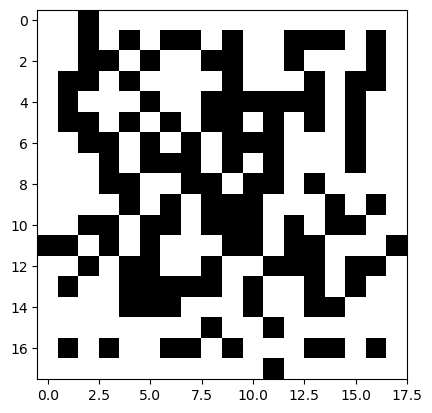

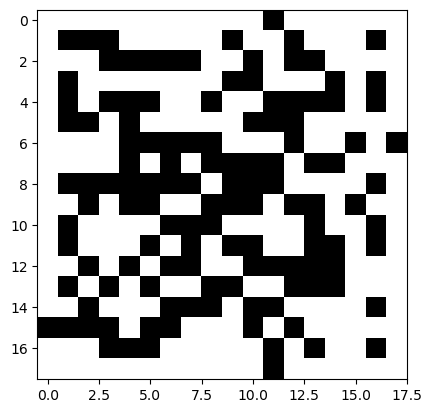

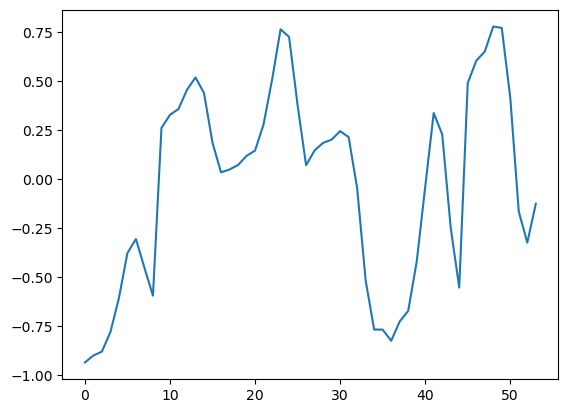

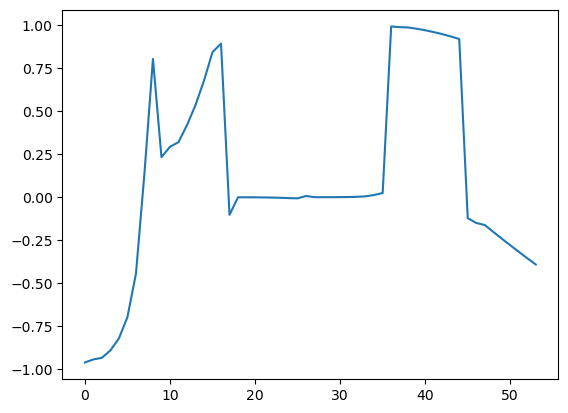

In [93]:
# preprocess_data(trial_name="trial_90000_data.s8p")
preprocess_data(trial_name="trial_16_data.s8p")



In [183]:
print(x_dataset.shape)

(301110, 18, 18)


In [23]:
print(x_dataset[0])

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0.]
 [0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0.]
 [0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0.]
 [0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.

In [185]:
test_x = np.load("/scratch/gpfs/sbfisher/EM250x300/data/x_data.npy")

In [187]:
test_x[0]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
        1., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1.,
        1., 0.],
       [0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
        1., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
        0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1.,
        0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        0., 0.],
       [1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
        0., 0.],
       [0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
        0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
        0., 0.],
       [0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
        0., 0.],
       [0., 1., 1., 0